In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import datetime as dt

In [ ]:
# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [70]:
df = pd.read_csv('transaction.csv', encoding='utf-8')

In [71]:
# 2. Data Understanding & Initial Cleaning
# -----------------------------------------------------------------------------

print("\n--- Initial Data Overview ---")
print(df.head())
print("\nData Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDescriptive Statistics:")
print(df.describe())


--- Initial Data Overview ---
   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID  
0  2010-12-01 08:26:00       2.95     17850.0  
1  2010-12-01 08:26:00       3.75     17850.0  
2  2010-12-01 08:26:00       4.15     17850.0  
3  2010-12-01 08:26:00       4.25     17850.0  
4  2010-12-01 08:26:00       4.25     17850.0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487619 entries, 0 to 487618
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    487619 non-null 

In [72]:
# Handle missing CustomerIDs: Drop rows where CustomerID is null
# As customer segmentation is the goal, rows without a customer ID are not useful.
df.dropna(inplace=True)

print(f"\nShape after dropping rows with null CustomerID: {df.shape}")
print("\nMissing Values after CustomerID drop:")
print(df.isnull().sum())


Shape after dropping rows with null CustomerID: (354320, 7)

Missing Values after CustomerID drop:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64


In [73]:
# Convert 'Invoice Date' to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("\n'InvoiceDate' data type after conversion:")
print(df['InvoiceDate'].dtype)


'InvoiceDate' data type after conversion:
datetime64[ns]


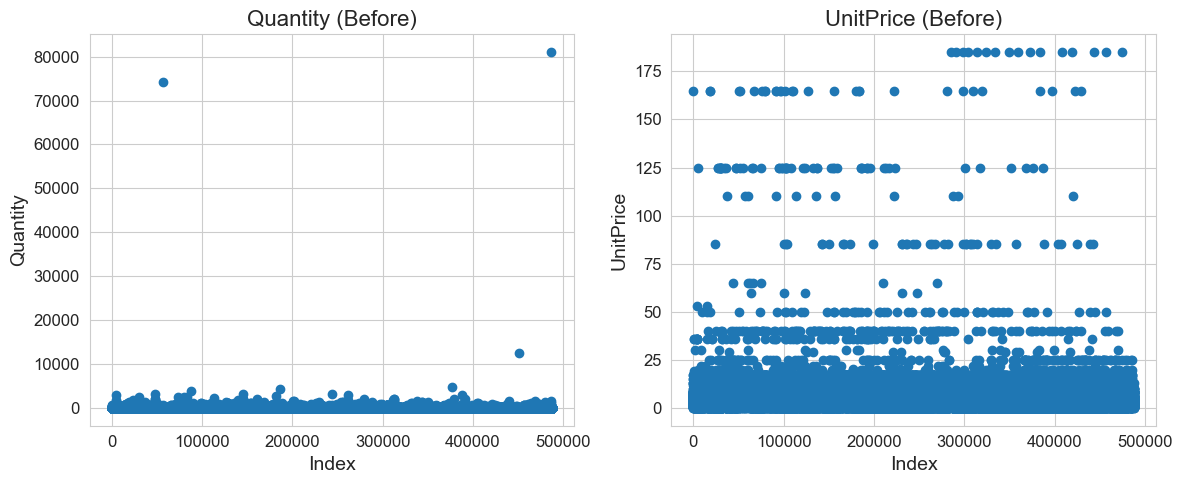

In [74]:
# 2. Plot BEFORE cleaning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df.index, df['Quantity'])
plt.title("Quantity (Before)")
plt.xlabel("Index")
plt.ylabel("Quantity")

plt.subplot(1, 2, 2)
plt.scatter(df.index, df['UnitPrice'])
plt.title("UnitPrice (Before)")
plt.xlabel("Index")
plt.ylabel("UnitPrice")

plt.tight_layout()
plt.show()

# 3. Store initial row count
before_rows = df.shape[0]

In [75]:
# 4. Remove top 1% outliers from the same DataFrame
q_thresh = df['Quantity'].quantile(0.99)
p_thresh = df['UnitPrice'].quantile(0.99)
df = df[(df['Quantity'] <= q_thresh) & (df['UnitPrice'] <= p_thresh)]

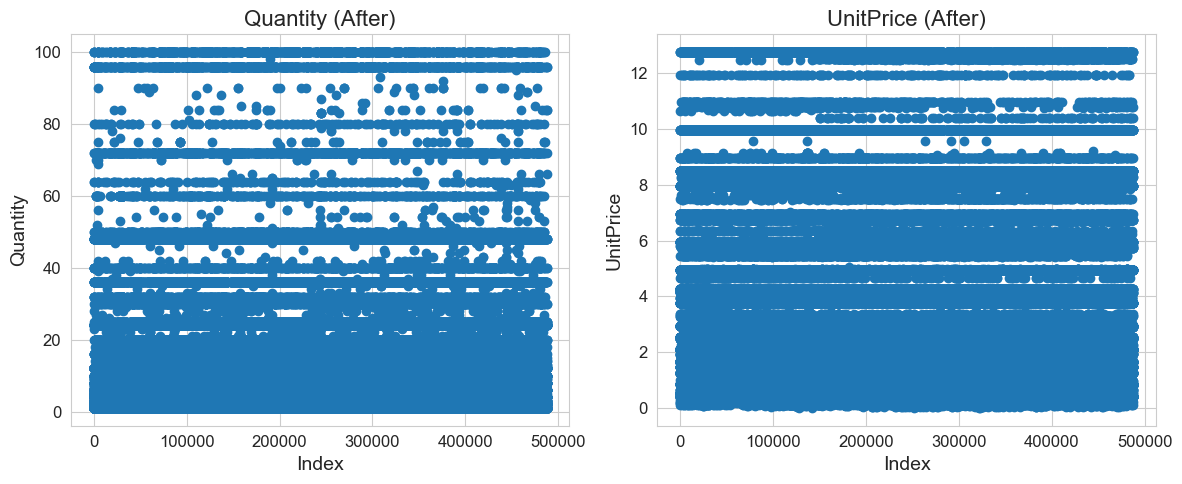

Rows before cleaning: 354320
Rows after cleaning: 347933
Rows removed: 6387


In [76]:
# 5. Plot AFTER cleaning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(df.index, df['Quantity'])
plt.title("Quantity (After)")
plt.xlabel("Index")
plt.ylabel("Quantity")

plt.subplot(1, 2, 2)
plt.scatter(df.index, df['UnitPrice'])
plt.title("UnitPrice (After)")
plt.xlabel("Index")
plt.ylabel("UnitPrice")

plt.tight_layout()
plt.show()

# 6. Summary of row counts
after_rows = df.shape[0]

print(f"Rows before cleaning: {before_rows}")
print(f"Rows after cleaning: {after_rows}")
print(f"Rows removed: {before_rows - after_rows}")

In [77]:
# 3. Feature Engineering & Data Preparation (RFM Analysis)
# -----------------------------------------------------------------------------

# Calculate TotalPrice for each transaction line
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [78]:
# Step 1: Convert StockCode to string
df['StockCode'] = df['StockCode'].astype(str)

# Step 2: Keep only rows with StockCodes that are 5, 6, or 7 characters long
df = df[df['StockCode'].str.len().isin([5, 6, 7])]

print(f"\nShape after filtering by StockCode length: {df.shape}")


Shape after filtering by StockCode length: (347658, 8)


In [79]:
df_filtered = df.copy()
# Convert Quantity and UnitPrice to numeric (coerce errors to NaN)
df_filtered['Quantity'] = pd.to_numeric(df_filtered['Quantity'], errors='coerce')
df_filtered['UnitPrice'] = pd.to_numeric(df_filtered['UnitPrice'], errors='coerce')

# Drop rows where conversion failed (i.e., NaNs)
df_filtered = df_filtered.dropna(subset=['Quantity', 'UnitPrice'])

# Filter positive quantities and unit prices
df_filtered = df_filtered[df_filtered['Quantity'] > 0]
df_filtered = df_filtered[df_filtered['UnitPrice'] > 0]

print(f"\nShape after cleaning: {df_filtered.shape}")


Shape after cleaning: (347657, 8)


In [80]:
# Aggregate duplicate items within the same invoice (as per PDF Page 10)
# This step ensures that if a customer buys the same item multiple times in one transaction,
# the quantity is summed up, preventing overcounting for frequency.
df_processed = df_filtered.groupby(['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID', 'UnitPrice'])['Quantity'].sum().reset_index()
df_processed['TotalPrice'] = df_processed['Quantity'] * df_processed['UnitPrice']

print(f"\nShape after aggregating duplicate items within invoices: {df_processed.shape}")
print("\nSample of processed data:")
print(df_processed.head())


Shape after aggregating duplicate items within invoices: (337745, 8)

Sample of processed data:
   InvoiceNo StockCode                          Description  \
0     536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER   
1     536365     22752         SET 7 BABUSHKA NESTING BOXES   
2     536365     71053                  WHITE METAL LANTERN   
3     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   
4     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   

          InvoiceDate  CustomerID  UnitPrice  Quantity  TotalPrice  
0 2010-12-01 08:26:00     17850.0       4.95         6        29.7  
1 2010-12-01 08:26:00     17850.0       8.50         2        17.0  
2 2010-12-01 08:26:00     17850.0       3.75         6        22.5  
3 2010-12-01 08:26:00     17850.0       4.25         6        25.5  
4 2010-12-01 08:26:00     17850.0       4.25         6        25.5  


In [81]:
# RFM Analysis
# Recency: Days since last purchase
# Frequency: Number of unique transactions
# Monetary: Total spending

# Define a snapshot date for Recency calculation (e.g., one day after the last transaction in the dataset)
snapshot_date = df_processed['InvoiceDate'].max() + dt.timedelta(days=1)
print(f"\nSnapshot Date for Recency Calculation: {snapshot_date}")

rfm_df = df_processed.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('TotalPrice', 'sum')
).reset_index()

print("\nRFM DataFrame Head:")
print(rfm_df.head())
print("\nRFM DataFrame Description:")
print(rfm_df.describe())


Snapshot Date for Recency Calculation: 2011-12-10 12:49:00

RFM DataFrame Head:
   CustomerID  Recency  Frequency  Monetary
0     12747.0        2         11   4691.61
1     12748.0        1        204  30105.81
2     12749.0        4          5   4044.92
3     12820.0        3          4    938.94
4     12821.0      214          1     92.72

RFM DataFrame Description:
         CustomerID      Recency    Frequency      Monetary
count   3875.000000  3875.000000  3875.000000   3875.000000
mean   15557.455484    92.354323     4.161806   1545.511092
std     1572.700162    99.679818     6.943119   3740.904263
min    12747.000000     1.000000     1.000000      2.900000
25%    14207.000000    18.000000     1.000000    283.995000
50%    15562.000000    51.000000     2.000000    637.900000
75%    16906.500000   144.000000     5.000000   1534.510000
max    18287.000000   374.000000   204.000000  84559.590000



--- Exploratory Data Analysis: Time-Series Trends & Overall RFM ---


/var/folders/9z/4w1fs4td6kndvkwpyj0bpr440000gn/T/ipykernel_90471/3393046531.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_processed.set_index('InvoiceDate').resample('M').agg(


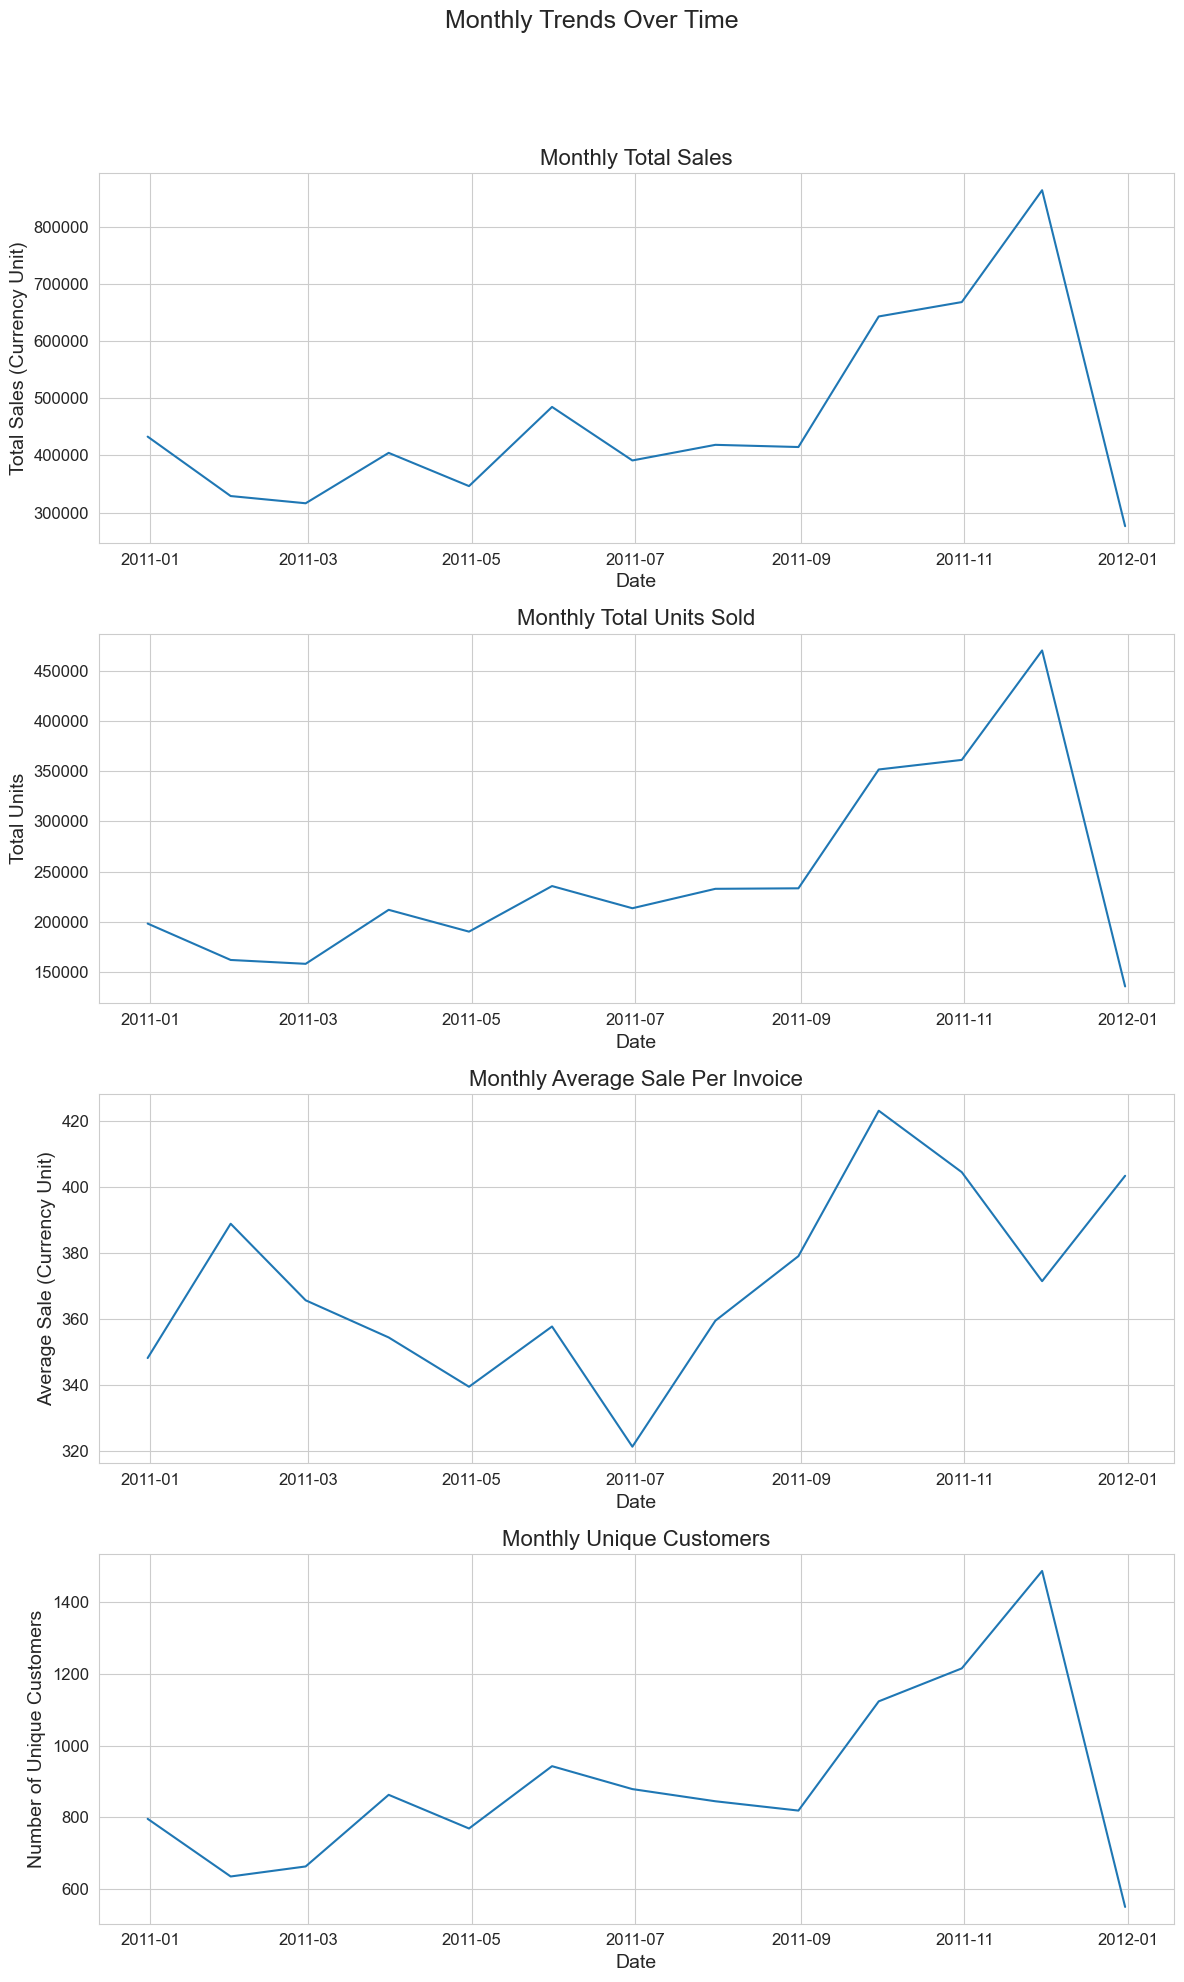

/var/folders/9z/4w1fs4td6kndvkwpyj0bpr440000gn/T/ipykernel_90471/3393046531.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overall_avg_rfm.index, y=overall_avg_rfm.values, palette='viridis')


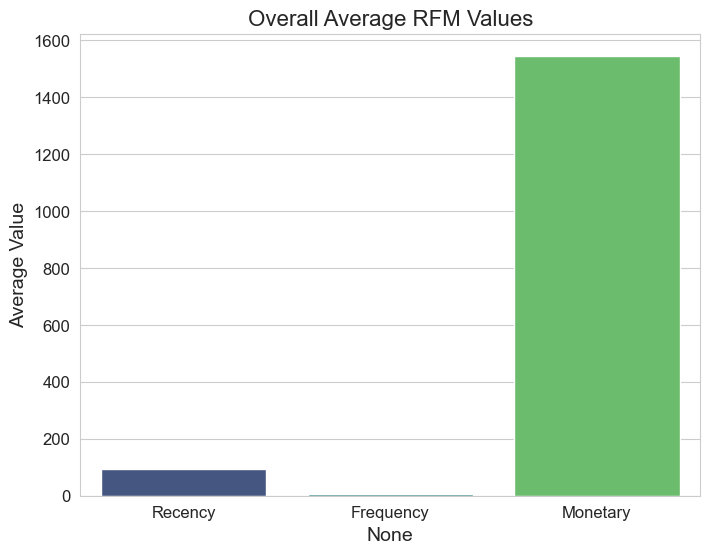

In [82]:
# --- New EDA: Time-Series Analysis and Overall RFM Averages ---
print("\n--- Exploratory Data Analysis: Time-Series Trends & Overall RFM ---")

# Prepare data for time-series plots
# Aggregate by month for trends
df_monthly = df_processed.set_index('InvoiceDate').resample('M').agg(
    TotalSales=('TotalPrice', 'sum'),
    TotalUnits=('Quantity', 'sum'),
    UniqueInvoices=('InvoiceNo', 'nunique'),
    UniqueCustomers=('CustomerID', 'nunique')
).reset_index()

# Calculate average sale per invoice
df_monthly['AverageSalePerInvoice'] = df_monthly['TotalSales'] / df_monthly['UniqueInvoices']

# Plotting time-series trends
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20))
fig.suptitle('Monthly Trends Over Time', y=1.02, fontsize=18)

# Monthly Total Sales
sns.lineplot(x='InvoiceDate', y='TotalSales', data=df_monthly, ax=axes[0])
axes[0].set_title('Monthly Total Sales')
axes[0].set_ylabel('Total Sales (Currency Unit)')
axes[0].set_xlabel('Date')

# Monthly Total Units Sold
sns.lineplot(x='InvoiceDate', y='TotalUnits', data=df_monthly, ax=axes[1])
axes[1].set_title('Monthly Total Units Sold')
axes[1].set_ylabel('Total Units')
axes[1].set_xlabel('Date')

# Monthly Average Sale Per Invoice
sns.lineplot(x='InvoiceDate', y='AverageSalePerInvoice', data=df_monthly, ax=axes[2])
axes[2].set_title('Monthly Average Sale Per Invoice')
axes[2].set_ylabel('Average Sale (Currency Unit)')
axes[2].set_xlabel('Date')

# Monthly Unique Customers
sns.lineplot(x='InvoiceDate', y='UniqueCustomers', data=df_monthly, ax=axes[3])
axes[3].set_title('Monthly Unique Customers')
axes[3].set_ylabel('Number of Unique Customers')
axes[3].set_xlabel('Date')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Overall Average RFM Values (Bar Plot)
overall_avg_rfm = rfm_df[['Recency', 'Frequency', 'Monetary']].mean()
plt.figure(figsize=(8, 6))
sns.barplot(x=overall_avg_rfm.index, y=overall_avg_rfm.values, palette='viridis')
plt.title('Overall Average RFM Values')
plt.ylabel('Average Value')
plt.show()

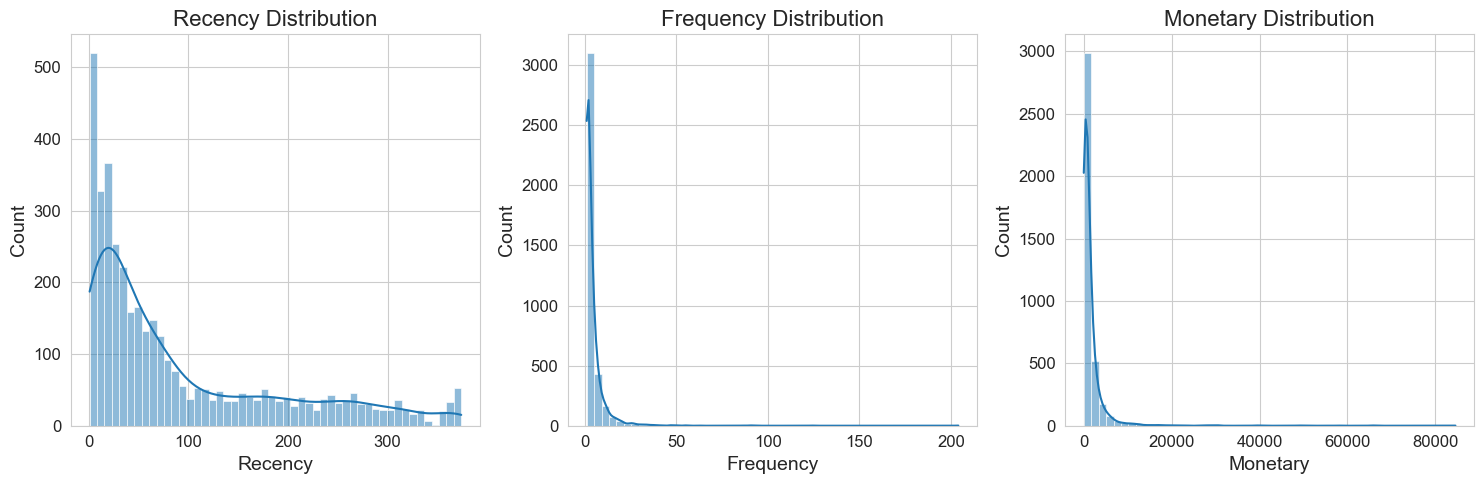

In [83]:
# Handle Outliers (Optional but Recommended for RFM)
# Visualize distributions to identify outliers
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=50, kde=True)
plt.title('Recency Distribution')
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency'], bins=50, kde=True)
plt.title('Frequency Distribution')
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary'], bins=50, kde=True)
plt.title('Monetary Distribution')
plt.tight_layout()
plt.show()


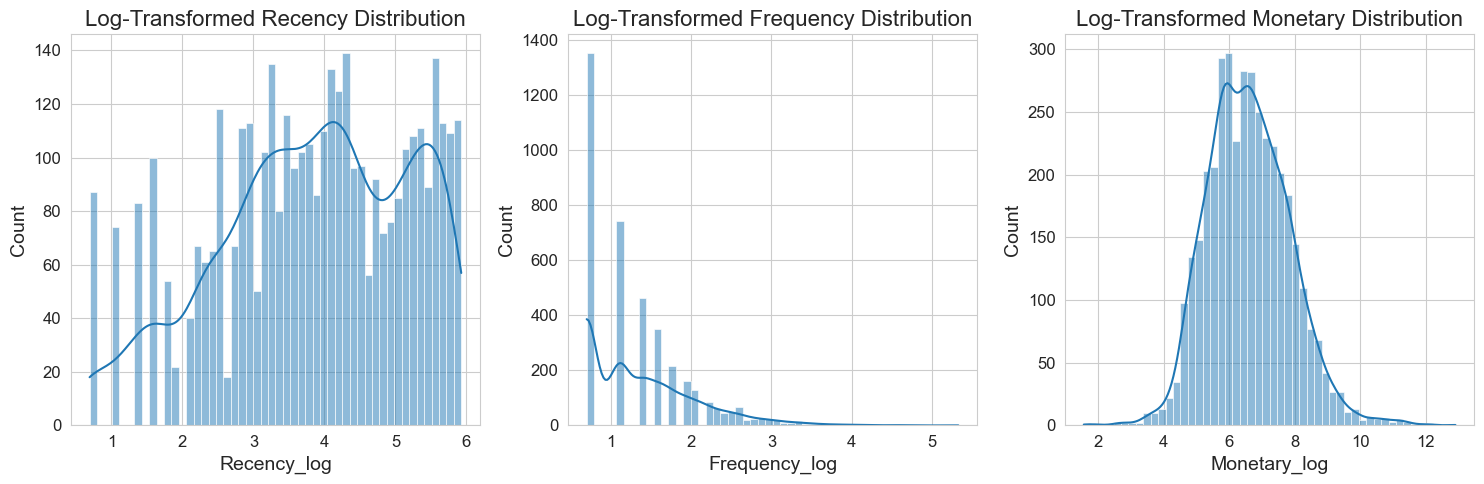

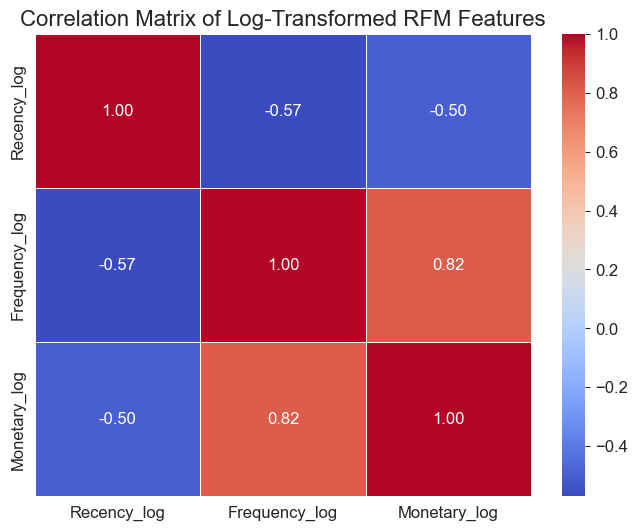

In [14]:
# Apply log transformation to Recency, Frequency and Monetary due to skewed distributions
# Add a small constant to avoid log(0) if there are zero values.
# Recency can be 0 for customers who purchased on the snapshot date, so log1p is good.
rfm_df['Recency_log'] = np.log1p(rfm_df['Recency'])
rfm_df['Frequency_log'] = np.log1p(rfm_df['Frequency'])
rfm_df['Monetary_log'] = np.log1p(rfm_df['Monetary'])

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency_log'], bins=50, kde=True)
plt.title('Log-Transformed Recency Distribution')
plt.subplot(1, 3, 2)
sns.histplot(rfm_df['Frequency_log'], bins=50, kde=True)
plt.title('Log-Transformed Frequency Distribution')
plt.subplot(1, 3, 3)
sns.histplot(rfm_df['Monetary_log'], bins=50, kde=True)
plt.title('Log-Transformed Monetary Distribution')
plt.tight_layout()
plt.show()

# Correlation Heatmap of Log-Transformed RFM Features
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_df[['Recency_log', 'Frequency_log', 'Monetary_log']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Log-Transformed RFM Features')
plt.show()


# Select features for clustering
X = rfm_df[['Recency_log', 'Frequency_log', 'Monetary_log']]

In [15]:
# 4. Data Scaling
# -----------------------------------------------------------------------------

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# IMPORTANT: Check for NaN or Inf values after scaling
# If any NaNs or Infs are present, it implies a fundamental issue with the data or scaling
if X_scaled_df.isnull().sum().sum() > 0:
    print("\nERROR: NaN values found in scaled data even after capping and log transform. This should not happen.")
    print(X_scaled_df.isnull().sum())
    exit() # Exit if critical issue persists

if np.isinf(X_scaled_df).sum().sum() > 0:
    print("\nERROR: Inf values found in scaled data even after capping and log transform. This should not happen.")
    print(np.isinf(X_scaled_df).sum())
    exit() # Exit if critical issue persists

# If X_scaled_df becomes empty after cleaning, handle it gracefully
if X_scaled_df.empty:
    print("\nERROR: Scaled DataFrame is empty after cleaning. Cannot proceed with clustering.")
    exit()

# Ensure rfm_df_cleaned is always defined and aligned with X_scaled_df
# We'll use the indices of X_scaled_df to filter rfm_df
rfm_df_cleaned = rfm_df.loc[X_scaled_df.index].copy()

print("\nScaled Data Head:")
print(X_scaled_df.head())
print("\nScaled Data Descriptive Statistics:")
print(X_scaled_df.describe())



Scaled Data Head:
   Recency_log  Frequency_log  Monetary_log
0     1.462821      -0.956244      3.854226
1    -2.035183       1.673426      1.485288
2    -2.337510       5.853008      3.313294
3    -1.654297       0.656130      1.367954
4    -1.820679       0.388547      0.200807

Scaled Data Descriptive Statistics:
        Recency_log  Frequency_log  Monetary_log
count  3.917000e+03   3.917000e+03  3.917000e+03
mean   5.441992e-18   4.027074e-16 -1.451198e-16
std    1.000128e+00   1.000128e+00  1.000128e+00
min   -2.337510e+00  -9.562444e-01 -4.006036e+00
25%   -6.588817e-01  -9.562444e-01 -6.856632e-01
50%    9.182103e-02  -3.611648e-01 -5.305647e-02
75%    8.512959e-01   6.561303e-01  6.430279e-01
max    1.564947e+00   5.853008e+00  5.023289e+00



--- Determining Optimal K using Elbow Method ---


/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_

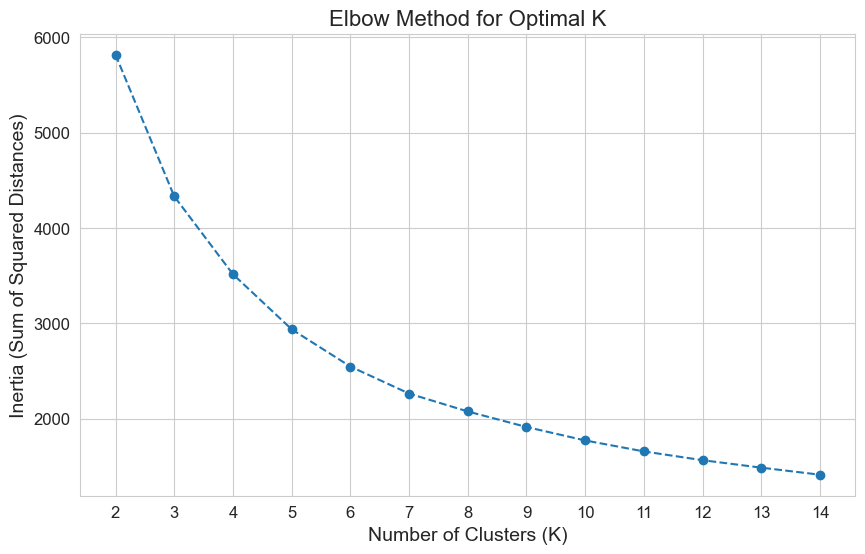


Observe the Elbow Method graph above to identify the optimal K.
The 'elbow' point is where the rate of decrease in inertia slows down significantly.
For example, if the elbow is at K=4, then 4 would be the optimal number of clusters.


In [16]:
# 5. K-means Clustering: Determining Optimal K using Elbow Method
# -----------------------------------------------------------------------------

print("\n--- Determining Optimal K using Elbow Method ---")

# Calculate inertia for a range of K values
inertia = []
k_range = range(2, 15) # Test K from 2 to 14

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_scaled_df)
    inertia.append(kmeans_model.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

print("\nObserve the Elbow Method graph above to identify the optimal K.")
print("The 'elbow' point is where the rate of decrease in inertia slows down significantly.")
print("For example, if the elbow is at K=4, then 4 would be the optimal number of clusters.")


In [17]:
best_k = 4 # <--- IMPORTANT: Replace this with the K you choose from the Elbow plot based on the plot you see

print(f"\nProceeding with K-Means clustering using best_k = {best_k} (chosen from Elbow Method).")

# Fit K-means with the best K found (or chosen)
final_kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_kmeans_model.fit(X_scaled_df) # Fit on the cleaned scaled data

# Assign cluster labels to the original RFM DataFrame (the cleaned one)
rfm_df_cleaned['Cluster'] = final_kmeans_model.labels_

print("\nRFM DataFrame with Cluster Labels Head:")
print(rfm_df_cleaned.head())


/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/furkan/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_


Proceeding with K-Means clustering using best_k = 4 (chosen from Elbow Method).

RFM DataFrame with Cluster Labels Head:
   CustomerID  Recency  Frequency   Monetary  Recency_log  Frequency_log  \
0     12346.0      326          1  92768.750     5.789960       0.693147   
1     12747.0        2         11   4722.510     1.098612       2.484907   
2     12748.0        1        206  47002.015     0.693147       5.332719   
3     12749.0        4          5   4074.820     1.609438       1.791759   
4     12820.0        3          4    938.940     1.386294       1.609438   

   Monetary_log  Cluster  
0     11.437876        2  
1      8.460307        1  
2     10.757967        1  
3      8.312827        1  
4      6.845816        3  



--- Cluster Analysis ---

Mean RFM values per Cluster (Original Scale):
   Cluster     Recency  Frequency     Monetary
0        0  181.192071   1.307587   337.574839
1        1   11.846761  13.625592  8153.884510
2        2   71.126177   4.126177  1784.063927
3        3   17.849802   2.188406   579.180613


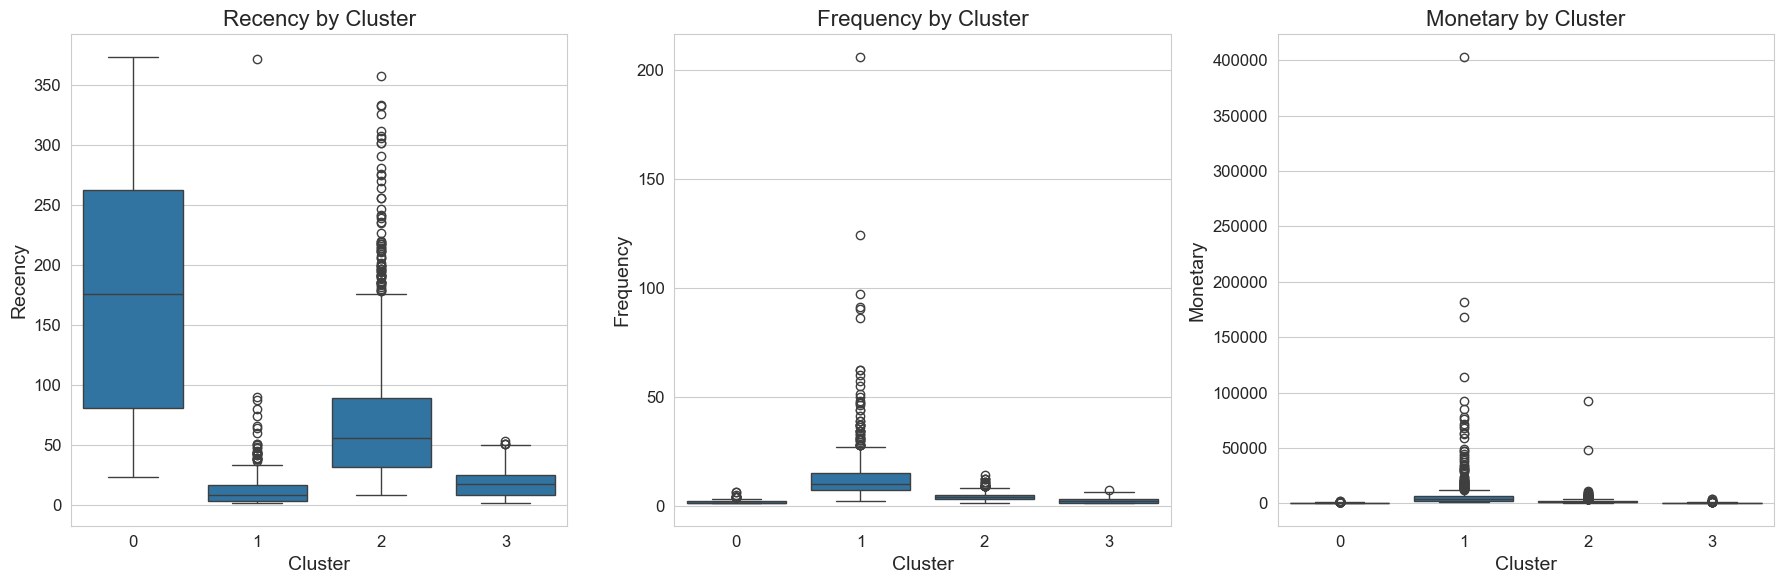

In [18]:
# 6. Cluster Analysis & Interpretation
# -----------------------------------------------------------------------------

print("\n--- Cluster Analysis ---")
cluster_summary = rfm_df_cleaned.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
print("\nMean RFM values per Cluster (Original Scale):")
print(cluster_summary)

# Visualize cluster characteristics (original scale for better interpretation)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm_df_cleaned)
plt.title('Recency by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm_df_cleaned)
plt.title('Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm_df_cleaned)
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.show()

In [19]:
# Further interpretation of clusters
# Based on the box plots and cluster_summary, describe each cluster.
# Example interpretation (will vary based on actual data results):
print("\n--- Cluster Interpretation ---")
# Ensure that the median calculation is based on the rfm_df_cleaned
recency_median = rfm_df_cleaned['Recency'].median()
frequency_median = rfm_df_cleaned['Frequency'].median()
monetary_median = rfm_df_cleaned['Monetary'].median()

for i in range(best_k):
    print(f"\nCluster {i}:")
    cluster_recency = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Recency'].values[0]
    cluster_frequency = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Frequency'].values[0]
    cluster_monetary = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Monetary'].values[0]

    print(f"  Average Recency: {cluster_recency:.2f} days")
    print(f"  Average Frequency: {cluster_frequency:.2f} transactions")
    print(f"  Average Monetary: {cluster_monetary:.2f} (currency unit)")

    # Provide a descriptive name for the cluster based on its RFM values
    if cluster_recency < recency_median and \
       cluster_frequency > frequency_median and \
       cluster_monetary > monetary_median:
        print(f"  Description: High-Value Loyal Customers (Recently purchased, frequent, high spending)")
    elif cluster_recency > recency_median and \
         cluster_frequency < frequency_median and \
         cluster_monetary < monetary_median:
        print(f"  Description: At-Risk/Churning Customers (Not purchased recently, infrequent, low spending)")
    elif cluster_recency < recency_median and \
         cluster_frequency < frequency_median and \
         cluster_monetary < monetary_median:
        print(f"  Description: New/Low-Value Customers (Recently purchased, but infrequent and low spending)")
    else:
        print(f"  Description: (Further analysis needed to precisely define this cluster)")



--- Cluster Interpretation ---

Cluster 0:
  Average Recency: 181.19 days
  Average Frequency: 1.31 transactions
  Average Monetary: 337.57 (currency unit)
  Description: At-Risk/Churning Customers (Not purchased recently, infrequent, low spending)

Cluster 1:
  Average Recency: 11.85 days
  Average Frequency: 13.63 transactions
  Average Monetary: 8153.88 (currency unit)
  Description: High-Value Loyal Customers (Recently purchased, frequent, high spending)

Cluster 2:
  Average Recency: 71.13 days
  Average Frequency: 4.13 transactions
  Average Monetary: 1784.06 (currency unit)
  Description: (Further analysis needed to precisely define this cluster)

Cluster 3:
  Average Recency: 17.85 days
  Average Frequency: 2.19 transactions
  Average Monetary: 579.18 (currency unit)
  Description: (Further analysis needed to precisely define this cluster)


In [20]:

# 7. Reporting & Recommendations
# -----------------------------------------------------------------------------

print("\n--- Business Recommendations ---")
print("Based on the identified customer segments, here are some potential business strategies:")

for i in range(best_k):
    print(f"\nFor Cluster {i}:")
    cluster_recency = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Recency'].values[0]
    cluster_frequency = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Frequency'].values[0]
    cluster_monetary = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Monetary'].values[0]

    if cluster_recency < recency_median and \
       cluster_frequency > frequency_median and \
       cluster_monetary > monetary_median:
        print("  Strategy: Retain and Reward. Offer exclusive loyalty programs, early access to new products, or personalized high-value recommendations to maintain their engagement.")
    elif cluster_recency > recency_median and \
         cluster_frequency < frequency_median and \
         cluster_monetary < monetary_median:
        print("  Strategy: Re-engagement Campaigns. Send targeted promotions, win-back offers, or surveys to understand reasons for inactivity and encourage return purchases.")
    elif cluster_recency < recency_median and \
         cluster_frequency < frequency_median and \
         cluster_monetary < monetary_median:
        print("  Strategy: Nurture and Upsell. Focus on increasing their purchase frequency and monetary value through introductory offers, product bundles, or educational content.")
    else:
        print("  Strategy: (Develop specific strategies based on the unique characteristics of this cluster from the analysis above.)")



--- Business Recommendations ---
Based on the identified customer segments, here are some potential business strategies:

For Cluster 0:
  Strategy: Re-engagement Campaigns. Send targeted promotions, win-back offers, or surveys to understand reasons for inactivity and encourage return purchases.

For Cluster 1:
  Strategy: Retain and Reward. Offer exclusive loyalty programs, early access to new products, or personalized high-value recommendations to maintain their engagement.

For Cluster 2:
  Strategy: (Develop specific strategies based on the unique characteristics of this cluster from the analysis above.)

For Cluster 3:
  Strategy: (Develop specific strategies based on the unique characteristics of this cluster from the analysis above.)


In [21]:
# 7. Reporting & Recommendations
# -----------------------------------------------------------------------------

print("\n--- Business Recommendations ---")
print("Based on the identified customer segments, here are some potential business strategies:")

for i in range(best_k):
    print(f"\nFor Cluster {i}:")
    cluster_recency = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Recency'].values[0]
    cluster_frequency = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Frequency'].values[0]
    cluster_monetary = cluster_summary.loc[cluster_summary['Cluster'] == i, 'Monetary'].values[0]

    if cluster_recency < rfm_df['Recency'].median() and \
       cluster_frequency > rfm_df['Frequency'].median() and \
       cluster_monetary > rfm_df['Monetary'].median():
        print("  Strategy: Retain and Reward. Offer exclusive loyalty programs, early access to new products, or personalized high-value recommendations to maintain their engagement.")
    elif cluster_recency > rfm_df['Recency'].median() and \
         cluster_frequency < rfm_df['Frequency'].median() and \
         cluster_monetary < rfm_df['Monetary'].median():
        print("  Strategy: Re-engagement Campaigns. Send targeted promotions, win-back offers, or surveys to understand reasons for inactivity and encourage return purchases.")
    elif cluster_recency < rfm_df['Recency'].median() and \
         cluster_frequency < rfm_df['Frequency'].median() and \
         cluster_monetary < rfm_df['Monetary'].median():
        print("  Strategy: Nurture and Upsell. Focus on increasing their purchase frequency and monetary value through introductory offers, product bundles, or educational content.")
    else:
        print("  Strategy: (Develop specific strategies based on the unique characteristics of this cluster from the analysis above.)")



--- Business Recommendations ---
Based on the identified customer segments, here are some potential business strategies:

For Cluster 0:
  Strategy: Re-engagement Campaigns. Send targeted promotions, win-back offers, or surveys to understand reasons for inactivity and encourage return purchases.

For Cluster 1:
  Strategy: Retain and Reward. Offer exclusive loyalty programs, early access to new products, or personalized high-value recommendations to maintain their engagement.

For Cluster 2:
  Strategy: (Develop specific strategies based on the unique characteristics of this cluster from the analysis above.)

For Cluster 3:
  Strategy: (Develop specific strategies based on the unique characteristics of this cluster from the analysis above.)


In [22]:
# Optional: Save the RFM DataFrame with cluster labels
rfm_df_cleaned.to_csv('customer_rfm_clusters.csv', index=False)
print("\n--- Analysis Complete ---")


--- Analysis Complete ---
